In [2]:
pip install librosa 

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn!=0.19.0,>=0.14.0 in c:\users\ulises\anaconda3\lib\site-packages (from librosa) (0.22.1)

  Created wheel for librosa: filename=librosa-0.7.2-py3-none-any.whl size=1612890 sha256=c9ab0376383a707d6993930cf096f862166227b439cbaa5bea0726be615faa6c
  Stored in directory: c:\users\ulises\appdata\local\pip\cache\wheels\18\9e\42\3224f85730f92fa2925f0b4fb6ef7f9c5431a64dfc77b95b39
  Created wheel for audioread: filename=audioread-2.1.8-py3-none-any.whl size=23095 sha256=d5f50b677dc3eb276ad0cec8e8c4568a22fb58b35b6ba87d07cb0662610a835a
  Stored in directory: c:\users\ulises\appdata\local\pip\cache\wheels\cd\85\04\704a589ef8773d1ec1393c4b271a023f929d85ef5317b12d8c
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320723 sha256=9d2c10bcd893dfc1cd9e6223b0c309e01af716be857be67c039ef27c0c07be99
  Stored in directory: c:\users\ulises\appdata\local\pip\cache\wheels\a0\18\0a\

In [116]:
import pandas as pd
import numpy as np
import librosa
import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D, Flatten, Dense, MaxPool2D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import IPython.display as ipd
from matplotlib import pyplot

In [121]:
def grab_sound_features(filename):
    sample_rate = 12000
    duration = 3

    # Cargamos el audio
    X, sample_rate = librosa.load(filename, sr=sample_rate, res_type='kaiser_fast')
    n_sample = X.shape[0]
    n_sample_fit = int(duration*sample_rate)

    # Si el audio es muy grande, limitamos la duracion del audio.
    # Si es audio es muy pequeño se completa con ceros.
    # En ambos casos ponemos un silencio de 0.5 segundos
    if n_sample < n_sample_fit:
        X = np.hstack((0.5*sample_rate, X, np.zeros(n_sample_fit - n_sample)))
    elif n_sample > n_sample_fit:
        X = np.hstack((0.5*sample_rate, X[int((n_sample-n_sample_fit)/2):int((n_sample+n_sample_fit)/2)]))
    
    return librosa.feature.melspectrogram(y=X, sr=sample_rate).transpose()

def parser():
    feature = []
    label = []
    # Funcion para cargar archivos y extraer caracteristicas
    for filename in glob.glob("data/scream/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(1)
    for filename in glob.glob("data/no-scream/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(0)
    return [feature, label]

In [122]:
data = np.array(parser())
n = data.shape[1]

In [123]:
data[0,0].shape

(71, 128)

In [124]:
data.shape

(2, 500)

In [125]:
X_ = data[0, :]
Y = data[1, :]
print(X_.shape, Y.shape)
X = np.empty([n, data[0,0].shape[0], data[0,0].shape[1]])

(500,) (500,)


In [126]:
X_[20].shape

(71, 128)

In [127]:
for i in range(n):
    X[i] = (X_[i])

In [128]:
data[0,0].shape[1]

128

In [129]:
Y = np.tile(Y,(data[0,0].shape[0],1)).transpose()

In [130]:
Y = to_categorical(Y)

In [131]:
print(X.shape)
print(Y.shape)

(500, 71, 128)
(500, 71, 2)


In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [133]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(375, 71, 128) (125, 71, 128) (375, 71, 2) (125, 71, 2)


In [49]:
# se ajusta el tamaño de los sets
#X_train = X_train.reshape(375, 71, 128, 1)
#X_test = X_test.reshape(125, 71, 128, 1)

In [50]:
(X_train.shape[1], X_train.shape[2])

(71, 128)

In [134]:
input_dim = (X_train.shape[1], X_train.shape[2])

In [117]:
input_dim = (71, 128)

In [135]:
input_dim

(71, 128)

In [136]:
# Crea el modelo en tensorflow keras 
model = Sequential()

model.add(Conv1D(128,kernel_size=3,strides=1, padding="same",activation="tanh",input_shape=input_dim))
model.add(Conv1D(64,kernel_size=3,strides=1, padding="same",activation="tanh"))
model.add(Conv1D(32,kernel_size=3,strides=1, padding="same",activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 71, 128)           49280     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 64)            24640     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 71, 32)            6176      
_________________________________________________________________
dropout_2 (Dropout)          (None, 71, 32)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 71, 2)             66        
Total params: 80,162
Trainable params: 80,162
Non-trainable params: 0
_________________________________________________________________


In [137]:
# se entrena el modelo en 50 epocas
history = model.fit(X_train, Y_train, epochs = 5, validation_data = (X_test, Y_test))

Train on 375 samples, validate on 125 samples
Epoch 1/5
375/375 [==============================] - 1s 3ms/sample - loss: 0.3966 - acc: 0.8474 - val_loss: 0.2606 - val_acc: 0.9055
Epoch 2/5
375/375 [==============================] - 0s 1ms/sample - loss: 0.2215 - acc: 0.9241 - val_loss: 0.2071 - val_acc: 0.9243
Epoch 3/5
375/375 [==============================] - 0s 1ms/sample - loss: 0.1603 - acc: 0.9406 - val_loss: 0.1644 - val_acc: 0.9360
Epoch 4/5
375/375 [==============================] - 0s 1ms/sample - loss: 0.1259 - acc: 0.9523 - val_loss: 0.1606 - val_acc: 0.9344
Epoch 5/5
375/375 [==============================] - 0s 1ms/sample - loss: 0.0976 - acc: 0.9618 - val_loss: 0.1295 - val_acc: 0.9512


In [138]:
# se muestra el accuracy final obtenido
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

125/125 [==============================] - 0s 417us/sample - loss: 0.1295 - acc: 0.9512
[0.1295184994339943, 0.9512113]


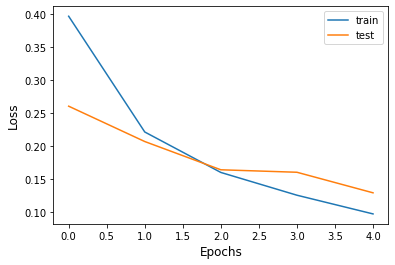

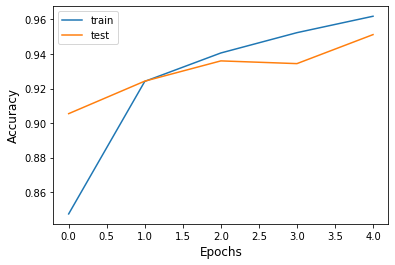

In [139]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Loss', fontsize = 12)
pyplot.show()
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Accuracy', fontsize = 12)
pyplot.show()

In [ ]:
################################################################################################################
################################################################################################################

In [140]:
def grab_sound_features_test(filename):
    sample_rate = 12000

    # Cargamos el audio
    X, sample_rate = librosa.load(filename, sr=sample_rate, res_type='kaiser_fast')
    
    return librosa.feature.melspectrogram(y=X, sr=sample_rate).transpose()

In [156]:
filename = "data/113_5.wav"
test = grab_sound_features(filename)

In [157]:
test.shape

(71, 128)

In [158]:
data_feature = test[None,:]

In [159]:
result = model.predict(data_feature)

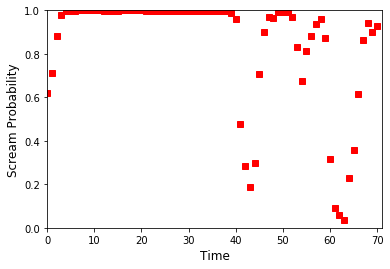

In [160]:
pyplot.plot(result[0,:,1], 'rs')
pyplot.xlabel('Time', fontsize = 12)
pyplot.ylabel('Scream Probability', fontsize = 12)
pyplot.axis([0, result.shape[1], 0, 1])
pyplot.show()
ipd.Audio(filename)